# Predict Tip Amount

Motivation: The appropriate tip amount for a passenger in a given scenario. In general scenarios, tips will also depend on the driver's service. Thus, the prediction will only give a general outline of the amount. Passengers will need to adjust according to how they felt.
The model will sum up the past data and we will assume that it represents the appropriate tip amount.

Our Dataset 2019-10 to 2020-03.
Assumption: Most recent will be most reliable. Before covid. Assume that tips should stay the same regardless of covid.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [354]:
# Yellow Taxi Data October 2019 to March 2020
datalist = ['2019-01', '2019-02', '2019-03', '2019-04', 
            '2019-05', '2019-06', '2019-07', '2019-08',
            '2019-09', '2019-10', '2019-11', '2019-12']
dflist = []
for i in datalist:
    dflist.append(pd.read_csv(f'yellow_tripdata_{i}.csv'))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [355]:
# Concat all dataframe rows
taxidf = pd.concat(dflist)

In [356]:
taxidf.shape

(84399019, 18)

In [357]:
# Passengers must be more than 0
taxidf = taxidf[taxidf['passenger_count'] > 0]
taxidf = taxidf[taxidf['passenger_count'] <= 6]

# Trip distance bigger than 0
taxidf = taxidf[taxidf['trip_distance'] > 0]

# Payment type by credit card for tips to be recorded properly
# cash and other types of payments dont have proper records of tips
taxidf = taxidf[taxidf['payment_type'] == 1]

# Starting fare amount is $2.5
taxidf = taxidf[taxidf['fare_amount'] >= 2.5]

# Drop missing values and duplicates
taxidf = taxidf.dropna()
taxidf = taxidf.drop_duplicates()

In [358]:
# Data too large, sample data
taxidf = taxidf.sample(frac =.3) 

In [359]:
taxidf.shape

(16739617, 18)

In [361]:
# Save the combined taxi dataset in feather format
taxidf.reset_index().to_feather('cleantaxidf.feather')

In [362]:
import feather
taxidf = feather.read_dataframe("cleantaxidf.feather").drop('index', axis=1)

In [363]:
taxidf.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,2.0000,2019-09-04 14:11:41,2019-09-04 14:19:06,1.0000,0.7000,1.0000,N,137,170,1.0000,6.0000,0.0000,0.5000,1.0000,0.0000,0.3000,10.3000,2.5000
1,2.0000,2019-09-16 20:13:59,2019-09-16 20:17:04,1.0000,1.1100,1.0000,N,162,237,1.0000,5.0000,0.5000,0.5000,1.7600,0.0000,0.3000,10.5600,2.5000
2,1.0000,2019-09-22 07:48:51,2019-09-22 07:54:58,1.0000,1.4000,1.0000,N,238,142,1.0000,7.5000,2.5000,0.5000,2.1500,0.0000,0.3000,12.9500,2.5000
3,1.0000,2019-04-01 17:55:09,2019-04-01 18:11:46,1.0000,2.0000,1.0000,N,161,113,1.0000,12.0000,3.5000,0.5000,3.2500,0.0000,0.3000,19.5500,2.5000
4,1.0000,2019-11-25 12:46:28,2019-11-25 13:05:18,1.0000,1.5000,1.0000,N,186,163,1.0000,12.5000,2.5000,0.5000,3.1500,0.0000,0.3000,18.9500,2.5000


## Trip Duration

In [364]:
taxidf['tpep_pickup_datetime'] = pd.to_datetime(taxidf.loc[:, ('tpep_pickup_datetime')])
taxidf['tpep_dropoff_datetime'] = pd.to_datetime(taxidf.loc[:, ('tpep_dropoff_datetime')])
taxidf['duration'] =  pd.to_timedelta(taxidf.loc[:, ('tpep_dropoff_datetime')] - taxidf.loc[:, ('tpep_pickup_datetime')]) / pd.offsets.Hour(1)

In [365]:
# get rid of invalid durations
taxidf = taxidf[taxidf['duration'] > 0]
taxidf = taxidf[taxidf['duration'] <= 3]

## Date-time to day & hour

In [366]:
taxidf['pickup_day'] = taxidf['tpep_pickup_datetime'].dt.dayofweek
taxidf['pickup_hour'] = taxidf['tpep_pickup_datetime'].dt.hour

taxidf['dropoff_day'] = taxidf['tpep_dropoff_datetime'].dt.dayofweek
taxidf['dropoff_hour'] = taxidf['tpep_dropoff_datetime'].dt.hour

taxidf['date'] = taxidf['tpep_pickup_datetime'].dt.date

In [367]:
taxidf.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration,pickup_day,pickup_hour,dropoff_day,dropoff_hour,date
0,2.0000,2019-09-04 14:11:41,2019-09-04 14:19:06,1.0000,0.7000,1.0000,N,137,170,1.0000,...,0.0000,0.3000,10.3000,2.5000,0.1236,2,14,2,14,2019-09-04
1,2.0000,2019-09-16 20:13:59,2019-09-16 20:17:04,1.0000,1.1100,1.0000,N,162,237,1.0000,...,0.0000,0.3000,10.5600,2.5000,0.0514,0,20,0,20,2019-09-16
2,1.0000,2019-09-22 07:48:51,2019-09-22 07:54:58,1.0000,1.4000,1.0000,N,238,142,1.0000,...,0.0000,0.3000,12.9500,2.5000,0.1019,6,7,6,7,2019-09-22
3,1.0000,2019-04-01 17:55:09,2019-04-01 18:11:46,1.0000,2.0000,1.0000,N,161,113,1.0000,...,0.0000,0.3000,19.5500,2.5000,0.2769,0,17,0,18,2019-04-01
4,1.0000,2019-11-25 12:46:28,2019-11-25 13:05:18,1.0000,1.5000,1.0000,N,186,163,1.0000,...,0.0000,0.3000,18.9500,2.5000,0.3139,0,12,0,13,2019-11-25


In [368]:
model_df = taxidf[['passenger_count', 'trip_distance', 'tip_amount', 'fare_amount', 'duration', 'pickup_day', 'pickup_hour', 'dropoff_hour', 'date']]

In [369]:
model_df.head()

,passenger_count,trip_distance,tip_amount,fare_amount,duration,pickup_day,pickup_hour,dropoff_hour,date
0,1.0000,0.7000,1.0000,6.0000,0.1236,2,14,14,2019-09-04
1,1.0000,1.1100,1.7600,5.0000,0.0514,0,20,20,2019-09-16
2,1.0000,1.4000,2.1500,7.5000,0.1019,6,7,7,2019-09-22
3,1.0000,2.0000,3.2500,12.0000,0.2769,0,17,18,2019-04-01
4,1.0000,1.5000,3.1500,12.5000,0.3139,0,12,13,2019-11-25


In [370]:
# Save the combined taxi dataset in feather format
model_df.reset_index().to_feather('model_df.feather')

In [371]:
import feather
model_df = feather.read_dataframe("model_df.feather").drop('index', axis=1)

In [372]:
model_df.shape

(16697202, 9)

## Weather dataset

In [374]:
weather_df = pd.read_csv('weather2019.csv')
weather_df.head(10)

,Unnamed: 0,date,time,condition
0,0,2019-01-01,1:51 AM,Light Rain
1,1,2019-01-01,2:51 AM,Light Rain
2,2,2019-01-01,3:45 AM,Fog
3,3,2019-01-01,3:51 AM,Fog
4,4,2019-01-01,4:15 AM,Light Rain
5,5,2019-01-01,4:20 AM,Fog
6,6,2019-01-01,4:51 AM,Light Drizzle
7,7,2019-01-01,4:55 AM,Light Drizzle
8,8,2019-01-01,5:41 AM,Cloudy
9,9,2019-01-01,5:51 AM,Cloudy


In [375]:
weather_df["date"] = pd.to_datetime(weather_df["date"]).dt.date
weather_df["time"] = pd.to_datetime(weather_df["time"]).dt.hour

weather_df.head()

,Unnamed: 0,date,time,condition
0,0,2019-01-01,1,Light Rain
1,1,2019-01-01,2,Light Rain
2,2,2019-01-01,3,Fog
3,3,2019-01-01,3,Fog
4,4,2019-01-01,4,Light Rain


## Preprocess weather
assume that bad weather affects tips

In [376]:
bad_weather = ['Fog', 'Cloudy', 'Mostly Cloudy / Windy', 'Rain', 'Partly Cloudy / Windy',
       'Wintry Mix', 'T-Storm', 'Cloudy / Windy', 'Heavy Rain', 'Rain / Windy', 'Snow / Windy',
       'Heavy Snow / Windy', 'Drizzle and Fog', 'Thunder', 'Light Rain with Thunder',
       'Heavy T-Storm / Windy', 'Haze', 'Heavy T-Storm',
       'Heavy Rain / Windy', 'Thunder in the Vicinity',
       'T-Storm / Windy', 'Thunder / Windy', 'Light Freezing Rain']

In [377]:
len(bad_weather)

23

In [378]:
len(weather_df.condition.unique())

39

In [379]:
weather_df['bad_weather'] = weather_df['condition']
weather_df['bad_weather'] = [1 if i in bad_weather else 0 for i in weather_df['bad_weather']]
weather_df.head()

,Unnamed: 0,date,time,condition,bad_weather
0,0,2019-01-01,1,Light Rain,0
1,1,2019-01-01,2,Light Rain,0
2,2,2019-01-01,3,Fog,1
3,3,2019-01-01,3,Fog,1
4,4,2019-01-01,4,Light Rain,0


In [380]:
weather_df['time'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23,  0])

In [381]:
joined_df = model_df.merge(weather_df, how='inner', left_on=["date", "pickup_hour"], right_on=["date","time"])

In [382]:
joined_df.drop('Unnamed: 0', axis='columns', inplace=True)

In [383]:
joined_df.head()

,passenger_count,trip_distance,tip_amount,fare_amount,duration,pickup_day,pickup_hour,dropoff_hour,date,time,condition,bad_weather
0,1.0000,0.7000,1.0000,6.0000,0.1236,2,14,14,2019-09-04,14,Mostly Cloudy,0
1,3.0000,2.2000,3.9600,16.5000,0.4378,2,14,14,2019-09-04,14,Mostly Cloudy,0
2,1.0000,2.5500,5.0000,15.5000,0.3803,2,14,14,2019-09-04,14,Mostly Cloudy,0
3,2.0000,16.6000,5.0000,65.0000,1.2128,2,14,15,2019-09-04,14,Mostly Cloudy,0
4,6.0000,0.3900,1.0000,3.5000,0.0233,2,14,14,2019-09-04,14,Mostly Cloudy,0


In [384]:
joined_df = joined_df[~joined_df.condition.isnull()]

In [385]:
joined_df.dropna()

,passenger_count,trip_distance,tip_amount,fare_amount,duration,pickup_day,pickup_hour,dropoff_hour,date,time,condition,bad_weather
0,1.0000,0.7000,1.0000,6.0000,0.1236,2,14,14,2019-09-04,14,Mostly Cloudy,0
1,3.0000,2.2000,3.9600,16.5000,0.4378,2,14,14,2019-09-04,14,Mostly Cloudy,0
2,1.0000,2.5500,5.0000,15.5000,0.3803,2,14,14,2019-09-04,14,Mostly Cloudy,0
3,2.0000,16.6000,5.0000,65.0000,1.2128,2,14,15,2019-09-04,14,Mostly Cloudy,0
4,6.0000,0.3900,1.0000,3.5000,0.0233,2,14,14,2019-09-04,14,Mostly Cloudy,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19483991,1.0000,2.2000,1.0000,10.0000,0.1639,3,21,21,2019-01-03,21,Mostly Cloudy,0
19483992,1.0000,1.5000,1.9500,8.0000,0.1458,4,17,18,2019-01-18,17,Cloudy,1
19483993,2.0000,9.4000,7.1000,29.0000,0.4144,6,4,5,2019-01-20,4,Rain,1
19483994,2.0000,1.8000,3.0500,9.0000,0.1867,6,20,20,2019-01-20,20,Fair / Windy,0


In [386]:
# Save the combined taxi dataset in feather format
joined_df.reset_index().to_feather('joined_df.feather')

In [1]:
import feather
joined_df = feather.read_dataframe("joined_df.feather").drop('index', axis=1)

In [5]:
joined_df.head()

,passenger_count,trip_distance,tip_amount,fare_amount,duration,pickup_day,pickup_hour,dropoff_hour,date,time,condition,bad_weather
0,1.0,0.70,1.00,6.0,0.123611,2,14,14,2019-09-04,14,Mostly Cloudy,0
1,3.0,2.20,3.96,16.5,0.437778,2,14,14,2019-09-04,14,Mostly Cloudy,0
2,1.0,2.55,5.00,15.5,0.380278,2,14,14,2019-09-04,14,Mostly Cloudy,0
3,2.0,16.60,5.00,65.0,1.212778,2,14,15,2019-09-04,14,Mostly Cloudy,0
4,6.0,0.39,1.00,3.5,0.023333,2,14,14,2019-09-04,14,Mostly Cloudy,0


In [389]:
joined_df.describe()

,passenger_count,trip_distance,tip_amount,fare_amount,duration,pickup_day,pickup_hour,dropoff_hour,time,bad_weather
count,"19,479,459.0000","19,479,459.0000","19,479,459.0000","19,479,459.0000","19,479,459.0000","19,479,459.0000","19,479,459.0000","19,479,459.0000","19,479,459.0000","19,479,459.0000"
mean,1.5744,3.0600,3.0666,13.3788,0.2485,2.8964,13.9666,14.0096,13.9666,0.2935
std,1.1912,3.9239,2.8062,11.8925,0.1962,1.9114,6.0289,6.1206,6.0289,0.4554
min,1.0000,0.0100,0.0000,2.5000,0.0003,0.0000,0.0000,0.0000,0.0000,0.0000
25%,1.0000,1.0000,1.7000,6.5000,0.1178,1.0000,10.0000,10.0000,10.0000,0.0000
50%,1.0000,1.7000,2.3600,9.5000,0.1942,3.0000,15.0000,15.0000,15.0000,0.0000
75%,2.0000,3.1000,3.4600,15.0000,0.3158,4.0000,19.0000,19.0000,19.0000,1.0000
max,6.0000,831.8000,"1,624.6400","9,022.0000",2.9983,6.0000,23.0000,23.0000,23.0000,1.0000


In [390]:
sample_df = joined_df.sample(frac=0.05, replace=True, random_state=1)

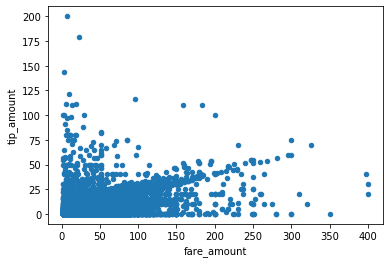

In [391]:
sample_df[['tip_amount', 'fare_amount']].plot.scatter(x='fare_amount', y='tip_amount')
plt.savefig('fare_amount.png')
plt.show()

In [392]:
joined_df = joined_df[joined_df['tip_amount'] < joined_df['fare_amount']]

In [393]:
sample_df = joined_df.sample(frac=0.05, replace=True, random_state=1)

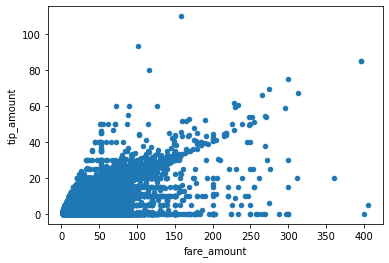

In [394]:
sample_df[['tip_amount', 'fare_amount']].plot.scatter(x='fare_amount', y='tip_amount')
plt.savefig('fare_amount2.png')
plt.show()

In [395]:
passenger_group = joined_df.groupby('passenger_count', as_index=False).mean()
passenger_group.head()

,passenger_count,trip_distance,tip_amount,fare_amount,duration,pickup_day,pickup_hour,dropoff_hour,time,bad_weather
0,1.0000,3.0266,3.0231,13.2825,0.2468,2.8393,13.8597,13.9089,13.8597,0.2945
1,2.0000,3.1934,3.1402,13.8207,0.2563,3.0696,14.3784,14.4022,14.3784,0.2901
2,3.0000,3.1089,3.1012,13.5700,0.2527,3.0795,14.3360,14.3640,14.3360,0.2887
3,4.0000,3.1609,3.1544,13.7967,0.2557,3.1540,14.3588,14.3754,14.3588,0.2891
4,5.0000,3.0824,3.0976,13.2518,0.2456,2.9482,14.0446,14.0644,14.0446,0.2944


No handles with labels found to put in legend.


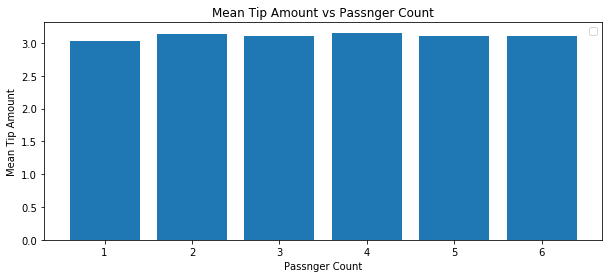

In [401]:
plt.figure(figsize = (10, 4))
plt.bar(passenger_group['passenger_count'], passenger_group['tip_amount'])
plt.title('Mean Tip Amount vs Passnger Count')
plt.xlabel('Passnger Count')
plt.ylabel('Mean Tip Amount')
plt.legend(loc='best')
plt.savefig('passenger_count.png')
plt.show()

In [402]:
pickup_hour_group = joined_df.groupby('pickup_hour', as_index=False).mean()
pickup_hour_group.head()

,pickup_hour,passenger_count,trip_distance,tip_amount,fare_amount,duration,pickup_day,dropoff_hour,time,bad_weather
0,0,1.6227,3.6810,3.1519,14.0205,0.2198,3.8501,0.1844,0.0000,0.3217
1,1,1.6231,3.3671,2.9048,12.9274,0.2000,4.2015,1.1690,1.0000,0.2756
2,2,1.6355,3.1586,2.7361,12.2537,0.1877,4.4302,2.1553,2.0000,0.2371
3,3,1.6342,3.3470,2.7759,12.7219,0.1884,4.5610,3.1704,3.0000,0.2878
4,4,1.5931,4.6811,3.4852,16.3408,0.2111,3.9692,4.1789,4.0000,0.2651


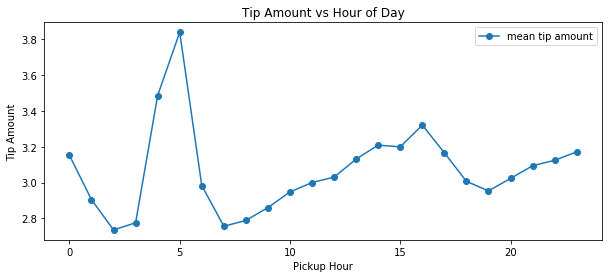

In [403]:
plt.figure(figsize = (10, 4))
plt.plot(pickup_hour_group['pickup_hour'], pickup_hour_group['tip_amount'], marker='o', label='mean tip amount')
plt.title('Tip Amount vs Hour of Day')
plt.xlabel('Pickup Hour')
plt.ylabel('Tip Amount')
plt.legend(loc='best')
plt.savefig('pickup_hour.png')
plt.show()

In [6]:
pickup_day_group = joined_df.groupby('pickup_day', as_index=False).mean()
pickup_day_group.head()

,pickup_day,passenger_count,trip_distance,tip_amount,fare_amount,duration,pickup_hour,dropoff_hour,time,bad_weather
0,0,1.546822,3.222035,3.133605,13.591298,0.243063,14.317267,14.419189,14.317267,0.273651
1,1,1.543097,2.947529,3.043403,13.169457,0.248966,14.189773,14.300816,14.189773,0.314546
2,2,1.543544,2.951736,3.087801,13.338362,0.256493,14.670287,14.751465,14.670287,0.318380
3,3,1.549613,3.007020,3.130719,13.651064,0.266528,14.369156,14.399553,14.369156,0.319116
4,4,1.574967,3.036934,3.085624,13.536167,0.258789,13.766306,13.747248,13.766306,0.301058


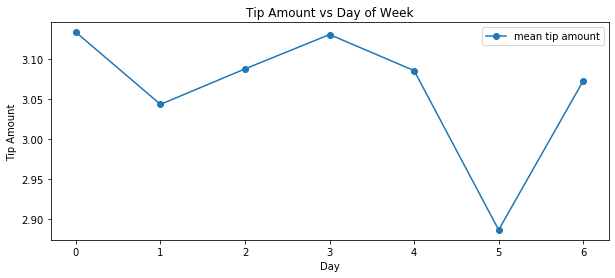

In [12]:
plt.figure(figsize = (10, 4))
plt.plot(pickup_day_group['pickup_day'], pickup_day_group['tip_amount'], marker='o', label='mean tip amount')
plt.title('Tip Amount vs Day of Week')
plt.xlabel('Day')
plt.ylabel('Tip Amount')
plt.legend(loc='best')
plt.savefig('pickup_day.png')
plt.show()
# 0 is monday and 6 is sunday

In [8]:
weather_group = joined_df.groupby('bad_weather', as_index=False).mean()
weather_group.head()

,bad_weather,passenger_count,trip_distance,tip_amount,fare_amount,duration,pickup_day,pickup_hour,dropoff_hour,time
0,0,1.575845,3.072911,3.066073,13.381371,0.247516,2.930075,13.972538,14.020816,13.972538
1,1,1.571070,3.029044,3.067790,13.372675,0.250905,2.815252,13.952300,13.982766,13.952300


No handles with labels found to put in legend.


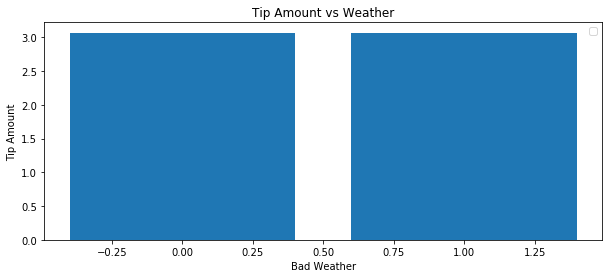

In [13]:
plt.figure(figsize = (10, 4))
plt.bar(weather_group['bad_weather'], weather_group['tip_amount'])
plt.title('Tip Amount vs Weather')
plt.xlabel('Bad Weather')
plt.ylabel('Tip Amount')
plt.legend(loc='best')
plt.savefig('weather.png')
plt.show()
# 0 is monday and 6 is sunday

## Train test Split

In [303]:
import feather
joined_df = feather.read_dataframe("joined_df.feather").drop('index', axis=1)

In [304]:
joined_df = joined_df.sample(frac =.05) 
joined_df.head()

,passenger_count,trip_distance,tip_amount,fare_amount,duration,pickup_day,pickup_hour,dropoff_hour,date,time,condition,bad_weather
11462964,4.0000,11.3500,5.0000,37.0000,0.6978,3,12,13,2019-06-20,12,Haze,1
5417414,1.0000,0.6200,1.0000,5.0000,0.0875,2,19,19,2019-03-06,19,Fair,0
12131014,1.0000,1.4000,1.5500,7.0000,0.1106,2,7,7,2019-03-20,7,Fair,0
13186638,1.0000,10.8700,7.0000,32.0000,0.3844,0,11,11,2019-08-12,11,Fair,0
16614738,1.0000,11.2000,7.2600,32.5000,0.3944,0,23,23,2019-03-25,23,Mostly Cloudy,0


In [2]:
joined_df = joined_df[['tip_amount', 'fare_amount', 'passenger_count', 'duration', 'pickup_day', 'pickup_hour']]

In [3]:
joined_df.shape

(19479459, 6)

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(joined_df, test_size=0.33, random_state=42)

In [5]:
test.shape

(6428222, 6)

In [6]:
train.shape

(13051237, 6)

## Random Forest

In [7]:
train.head(7)

,tip_amount,fare_amount,passenger_count,duration,pickup_day,pickup_hour
13718037,4.26,17.0,1.0,0.385278,3,17
3853218,1.85,6.0,3.0,0.104444,4,8
16546932,3.16,12.5,1.0,0.318889,4,16
18953381,1.46,4.0,3.0,0.043333,0,6
17917618,9.46,46.5,1.0,0.659167,1,9
17130636,3.36,13.0,1.0,0.264167,1,22
17475156,1.45,5.0,1.0,0.072778,5,15


In [311]:
X_train = train.loc[:, joined_df.columns != 'tip_amount']
y_train = train['tip_amount']
X_test = test.loc[:, joined_df.columns != 'tip_amount']
y_test = test['tip_amount']

In [312]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rf = RandomForestRegressor(max_depth=9, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)
predict = rf.predict(X_test)
mean_squared_error(y_test, predict, squared=False)

CPU times: user 9.74 s, sys: 7.92 ms, total: 9.75 s
Wall time: 9.75 s


1.7724274650052376

In [313]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predict, squared=False)

1.7724274650052376

In [9]:
import numpy as np

In [11]:
[int(x) for x in np.linspace(5, 10, num = 5)]

[5, 6, 7, 8, 10]

In [318]:
# code from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 6, 7, 8, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [319]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 6, 7, 8, 10, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 31, 52, 73, 94,
                                                         115, 136, 157, 178,
                                                         200]},
                   random_state=42, verbose=2)

In [320]:
rf_random.best_params_

{'n_estimators': 52,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 7,
 'bootstrap': True}

In [321]:
from sklearn.metrics import mean_squared_error

best_random = rf_random.best_estimator_
predictions = best_random.predict(X_test)
mean_squared_error(y_test, predictions, squared=False)

1.768171672881021

## TUNING

### MAX_DEPTH

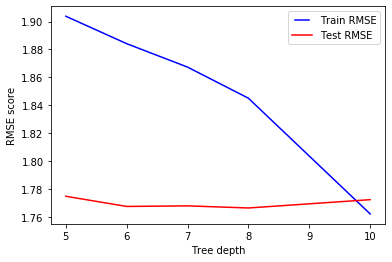

CPU times: user 8min 2s, sys: 610 ms, total: 8min 3s
Wall time: 18.2 s


In [329]:
%%time
from sklearn.metrics import mean_squared_error
max_depths = [int(x) for x in np.linspace(5, 10, num = 5)]
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestRegressor(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    train_pred = rf.predict(X_train)
    train_res = mean_squared_error(y_train, train_pred, squared=False)
    train_results.append(train_res)
    
    y_pred = rf.predict(X_test)
    test_res = mean_squared_error(y_test, y_pred, squared=False)
    test_results.append(test_res)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train RMSE")
line2, = plt.plot(max_depths, test_results, "r", label="Test RMSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("RMSE score")
plt.xlabel("Tree depth")
plt.show()

### min_samples_split

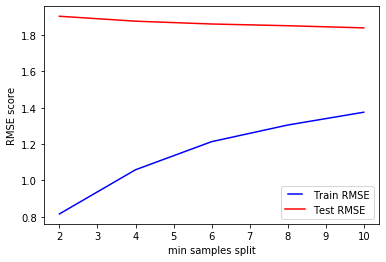

CPU times: user 22min 29s, sys: 3.55 s, total: 22min 33s
Wall time: 45.3 s


In [333]:
%%time
from sklearn.metrics import mean_squared_error
min_samples_split = [2, 4, 6, 8, 10]
train_results = []
test_results = []
for sample in min_samples_split:
    rf = RandomForestRegressor(min_samples_split = sample, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    train_pred = rf.predict(X_train)
    train_res = mean_squared_error(y_train, train_pred, squared=False)
    train_results.append(train_res)
    
    y_pred = rf.predict(X_test)
    test_res = mean_squared_error(y_test, y_pred, squared=False)
    test_results.append(test_res)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_split, train_results, "b", label="Train RMSE")
line2, = plt.plot(min_samples_split, test_results, "r", label="Test RMSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("RMSE score")
plt.xlabel("min samples split")
plt.show()

### n_estimators

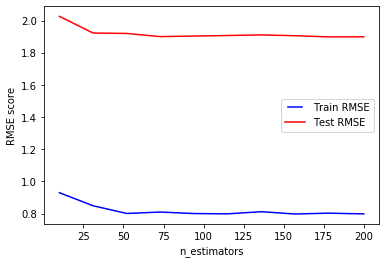

CPU times: user 54min 10s, sys: 22.5 s, total: 54min 32s
Wall time: 1min 55s


In [330]:
%%time
from sklearn.metrics import mean_squared_error
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
train_results = []
test_results = []
for n_estimates in n_estimators:
    rf = RandomForestRegressor(n_estimators=n_estimates, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    train_pred = rf.predict(X_train)
    train_res = mean_squared_error(y_train, train_pred, squared=False)
    train_results.append(train_res)
    
    y_pred = rf.predict(X_test)
    test_res = mean_squared_error(y_test, y_pred, squared=False)
    test_results.append(test_res)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train RMSE")
line2, = plt.plot(n_estimators, test_results, "r", label="Test RMSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("RMSE score")
plt.xlabel("n_estimators")
plt.show()

### min_samples_leaf

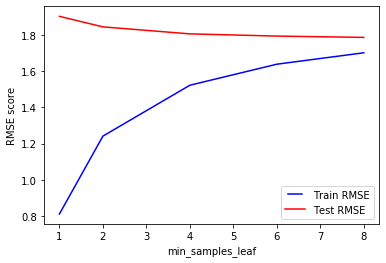

CPU times: user 20min 54s, sys: 2.88 s, total: 20min 57s
Wall time: 43.4 s


In [334]:
%%time
from sklearn.metrics import mean_squared_error
min_samples_leaf = [1, 2, 4, 6, 8]
train_results = []
test_results = []
for sample in min_samples_leaf:
    rf = RandomForestRegressor(min_samples_leaf=sample, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    train_pred = rf.predict(X_train)
    train_res = mean_squared_error(y_train, train_pred, squared=False)
    train_results.append(train_res)
    
    y_pred = rf.predict(X_test)
    test_res = mean_squared_error(y_test, y_pred, squared=False)
    test_results.append(test_res)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leaf, train_results, "b", label="Train RMSE")
line2, = plt.plot(min_samples_leaf, test_results, "r", label="Test RMSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("RMSE score")
plt.xlabel("min_samples_leaf")
plt.show()

In [ ]:
plt.savefig('max_depth.png')

## OLS

In [235]:
from statsmodels.formula.api import *

In [279]:
fitter1 = ols(formula="tip_amount ~ passenger_count + fare_amount + duration + pickup_day + pickup_hour + bad_weather",
         data=train).fit()
print(fitter1.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                 2.767e+05
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        08:29:13   Log-Likelihood:            -2.6642e+06
No. Observations:             1305200   AIC:                         5.328e+06
Df Residuals:                 1305193   BIC:                         5.329e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5477      0.006     

In [288]:
from statsmodels.tools.eval_measures import rmse

pred = fitter1.predict(test)
rmse(y_test, pred, axis=0)

1.934022745629077

In [281]:
fitter2 = ols(formula="tip_amount ~ passenger_count + duration + pickup_day + pickup_hour",
         data=train).fit()
print(fitter2.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                 2.259e+05
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        08:29:29   Log-Likelihood:            -2.8565e+06
No. Observations:             1305200   AIC:                         5.713e+06
Df Residuals:                 1305195   BIC:                         5.713e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7650      0.007    1

In [282]:
from statsmodels.tools.eval_measures import rmse

pred = fitter2.predict(test)
rmse(y_test, pred, axis=0)

2.2217603701959137

In [290]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
print('R-squared:', lr.score(X_test, y_test))

R-squared: 0.5419741937432497


In [289]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_test_pred, squared=False)

1.934022745629077

In [252]:
train.head()

,tip_amount,passenger_count,duration,pickup_day,pickup_hour,bad_weather
15381345,2.5500,2.0000,0.2578,5,14,0
6135911,2.3500,1.0000,0.1644,2,17,0
3353542,1.0000,3.0000,0.1350,4,17,0
13092546,2.7500,4.0000,0.2122,5,22,0
14499940,1.0000,6.0000,0.2697,6,0,1


In [253]:
train.head()

,tip_amount,passenger_count,duration,pickup_day,pickup_hour,bad_weather
15381345,2.5500,2.0000,0.2578,5,14,0
6135911,2.3500,1.0000,0.1644,2,17,0
3353542,1.0000,3.0000,0.1350,4,17,0
13092546,2.7500,4.0000,0.2122,5,22,0
14499940,1.0000,6.0000,0.2697,6,0,1
